In [4]:
from parsing import Parser
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
conn = psycopg2.connect(host="localhost", dbname='postgres', user='postgres', password='123456', port=5432)
cur = conn.cursor()

len = 131
start = 16

maps = []
dataset = []

query = """
        SELECT dataset.map_name
        FROM dataset
        """
cur.execute(query)
for row in cur.fetchall():
    maps.append(row[0])

for index in range(len):
    query = f"""
            SELECT dataset.t1_winstreak,dataset.t2_winstreak,dataset.t1_h2h,dataset.t2_h2h,
                            dataset.t1_ranking,dataset.t2_ranking,dataset.t1_weeks,dataset.t2_weeks,dataset.t1_age,dataset.t2_age,dataset.t1_rating,dataset.t2_rating,
                            dataset.t1_winrate,dataset.t2_winrate,dataset.t1_5v4,dataset.t2_5v4,dataset.t1_4v5,dataset.t2_4v5,dataset.t1_maps,dataset.t2_maps,  
                            dataset.t1_pistol,dataset.t2_pistol,win,betting_info.rounds_lost_{maps[index]}, betting_info.rounds_won_{maps[index]}, betting_info.fp_{maps[index]}, betting_info.fp_percent_{maps[index]}
            FROM dataset
            FULL OUTER JOIN betting_info ON dataset.t1_name = betting_info.team
            WHERE dataset.id = {start+index}
            """
    cur.execute(query)
    row = cur.fetchall()[0]
    query = f"""
            SELECT betting_info.rounds_lost_{maps[index]}, betting_info.rounds_won_{maps[index]}, betting_info.fp_{maps[index]}, betting_info.fp_percent_{maps[index]}
            FROM dataset
            FULL OUTER JOIN betting_info ON dataset.t2_name = betting_info.team
            WHERE dataset.id = {start+index}
            """
    cur.execute(query)
    row += cur.fetchall()[0]

    if start+index < 73:

        query = f"""
                SELECT blast_fall_groups2023_rating.team_rating, blast_fall_groups2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN blast_fall_groups2023_rating ON dataset.t1_name = blast_fall_groups2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT blast_fall_groups2023_rating.team_rating, blast_fall_groups2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN blast_fall_groups2023_rating ON dataset.t2_name = blast_fall_groups2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 73 and start+index < 147:

        query = f"""
                SELECT iem_cologne2023_rating.team_rating, iem_cologne2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN iem_cologne2023_rating ON dataset.t1_name = iem_cologne2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT iem_cologne2023_rating.team_rating, iem_cologne2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN iem_cologne2023_rating ON dataset.t2_name = iem_cologne2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    dataset.append(row)
conn.close()

print(dataset)

[(0.0, 0.0, 0.0, 0.0, 9.0, 4.0, 6.0, 83.0, 24.2, 25.7, 5.11, 5.42, 0.6, 0.562, 0.662, 0.756, 0.281, 0.298, 5.0, 16.0, 0.5, 0.656, True, 14.0, 10.5, False, 0.07, 8.5, 11.33, True, 0.61, 1.04, 5.2, 1.03, 5.16), (0.0, 0.0, 0.0, 0.0, 9.0, 4.0, 6.0, 83.0, 24.2, 25.7, 5.11, 5.42, 0.571, 0.5, 0.689, 0.764, 0.264, 0.282, 7.0, 10.0, 0.714, 0.35, True, 11.75, 7.33, True, 0.29, 10.5, 11.5, False, 0.1, 1.04, 5.2, 1.03, 5.16), (0.0, 0.0, 0.0, 1.0, 1.0, 24.0, 85.0, 16.0, 24.4, 23.4, 5.49, 5.24, 0.667, 0.333, 0.734, 0.703, 0.293, 0.243, 9.0, 3.0, 0.5, 0.333, True, 13.0, 11.0, False, 0.24, 7.0, 9.5, False, 0.15, 1.16, 5.82, 0.97, 4.85), (0.0, 0.0, 0.0, 1.0, 1.0, 24.0, 85.0, 16.0, 24.4, 23.4, 5.49, 5.24, 0.8, 0.5, 0.803, 0.661, 0.336, 0.22, 10.0, 4.0, 0.5, 0.75, True, 9.14, 9.0, False, 0.14, 13.0, 8.0, False, 0.15, 1.16, 5.82, 0.97, 4.85), (0.0, 0.0, 2.0, 1.0, 13.0, 6.0, 54.0, 35.0, 23.2, 23.5, 5.06, 5.41, 0.2, 0.615, 0.727, 0.78, 0.205, 0.273, 5.0, 13.0, 0.7, 0.423, False, 9.0, 10.0, False, 0.16, 8.43

In [3]:
df = pd.DataFrame(dataset, columns=["t1_winstreak","t2_winstreak","t1_h2h","t2_h2h",
                            "t1_ranking","t2_ranking","t1_weeks","t2_weeks","t1_age","t2_age","t1_rating","t2_rating",
                            "t1_winrate","t2_winrate","t1_5v4","t2_5v4","t1_4v5","t2_4v5","t1_maps","t2_maps",  
                            "t1_pistol","t2_pistol","win","t1_rounds_lost", "t1_rounds_won", "t1_fp", "t1_fp_percent",
                            "t2_rounds_lost", "t2_rounds_won", "t2_fp", "t2_fp_percent","t1_team_rating","t1_event_rating",
                            "t2_team_rating","t2_event_rating"])
df.head

<bound method NDFrame.head of      t1_winstreak  t2_winstreak  t1_h2h  t2_h2h  t1_ranking  t2_ranking   
0             0.0           0.0     0.0     0.0         9.0         4.0  \
1             0.0           0.0     0.0     0.0         9.0         4.0   
2             0.0           0.0     0.0     1.0         1.0        24.0   
3             0.0           0.0     0.0     1.0         1.0        24.0   
4             0.0           0.0     2.0     1.0        13.0         6.0   
..            ...           ...     ...     ...         ...         ...   
126           0.0           6.0     0.0     0.0         8.0        16.0   
127           0.0           6.0     0.0     0.0         8.0        16.0   
128           0.0           6.0     0.0     0.0         8.0        16.0   
129           0.0           0.0     2.0     0.0         7.0        14.0   
130           0.0           0.0     2.0     0.0         7.0        14.0   

     t1_weeks  t2_weeks  t1_age  t2_age  ...  t1_fp  t1_fp_percent   

In [6]:
df.describe()

,t1_winstreak,t2_winstreak,t1_h2h,t2_h2h,t1_ranking,t2_ranking,t1_weeks,t2_weeks,t1_age,t2_age,t1_rating,t2_rating,t1_winrate,t2_winrate,t1_5v4,t2_5v4,t1_4v5,t2_4v5,t1_maps,t2_maps,t1_pistol,t2_pistol,t1_rounds_lost,t1_rounds_won,t1_fp_percent,t2_rounds_lost,t2_rounds_won,t2_fp_percent,t1_team_rating,t1_event_rating,t2_team_rating,t2_event_rating
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,1.045802,0.877863,2.114504,1.641221,8.633588,11.511450,78.595420,53.358779,24.470229,23.900000,5.274733,5.221527,0.558710,0.515924,0.730344,0.719565,0.298321,0.284053,7.488550,7.396947,0.482824,0.507122,10.365725,10.390916,0.187405,10.898015,10.519313,0.197557,1.040840,5.206183,1.015344,5.081298
std,1.987896,2.105023,3.175970,2.683479,8.652440,7.892905,53.597184,41.539614,1.567737,1.407179,0.187622,0.195725,0.192475,0.209954,0.060651,0.056734,0.052965,0.055920,3.435933,3.707953,0.140971,0.160938,3.276216,3.076425,0.148845,3.367193,2.940055,0.171433,0.073975,0.376801,0.075318,0.378512
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,19.900000,19.900000,4.800000,4.800000,0.000000,0.000000,0.500000,0.574000,0.125000,0.135000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.910000,4.540000,0.840000,4.220000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,6.000000,35.000000,17.000000,23.400000,23.400000,5.140000,5.110000,0.500000,0.400000,0.700000,0.675000,0.268000,0.236000,5.000000,5.000000,0.394500,0.400000,8.430000,9.000000,0.060000,9.000000,9.000000,0.060000,0.990000,4.960000,0.970000,4.850000
50%,0.000000,0.000000,1.000000,1.000000,6.000000,9.000000,83.000000,43.000000,24.300000,23.500000,5.270000,5.240000,0.562000,0.500000,0.725000,0.720000,0.298000,0.289000,7.000000,6.000000,0.500000,0.500000,10.380000,10.600000,0.160000,11.000000,10.670000,0.150000,1.040000,5.200000,1.020000,5.090000
75%,0.000000,0.000000,2.000000,2.000000,10.000000,18.000000,130.000000,83.000000,25.700000,24.200000,5.420000,5.410000,0.707000,0.667000,0.772000,0.767000,0.333000,0.318000,10.000000,9.000000,0.577000,0.625000,12.250000,11.835000,0.255000,12.500000,12.000000,0.290000,1.090000,5.460000,1.055000,5.270000
max,7.000000,9.000000,16.000000,12.000000,40.000000,40.000000,175.000000,175.000000,27.400000,27.400000,5.550000,5.550000,1.000000,1.000000,0.871000,0.807000,0.403000,0.446000,16.000000,18.000000,0.833000,0.917000,20.000000,17.000000,0.610000,20.000000,17.000000,0.670000,1.180000,5.920000,1.180000,5.920000


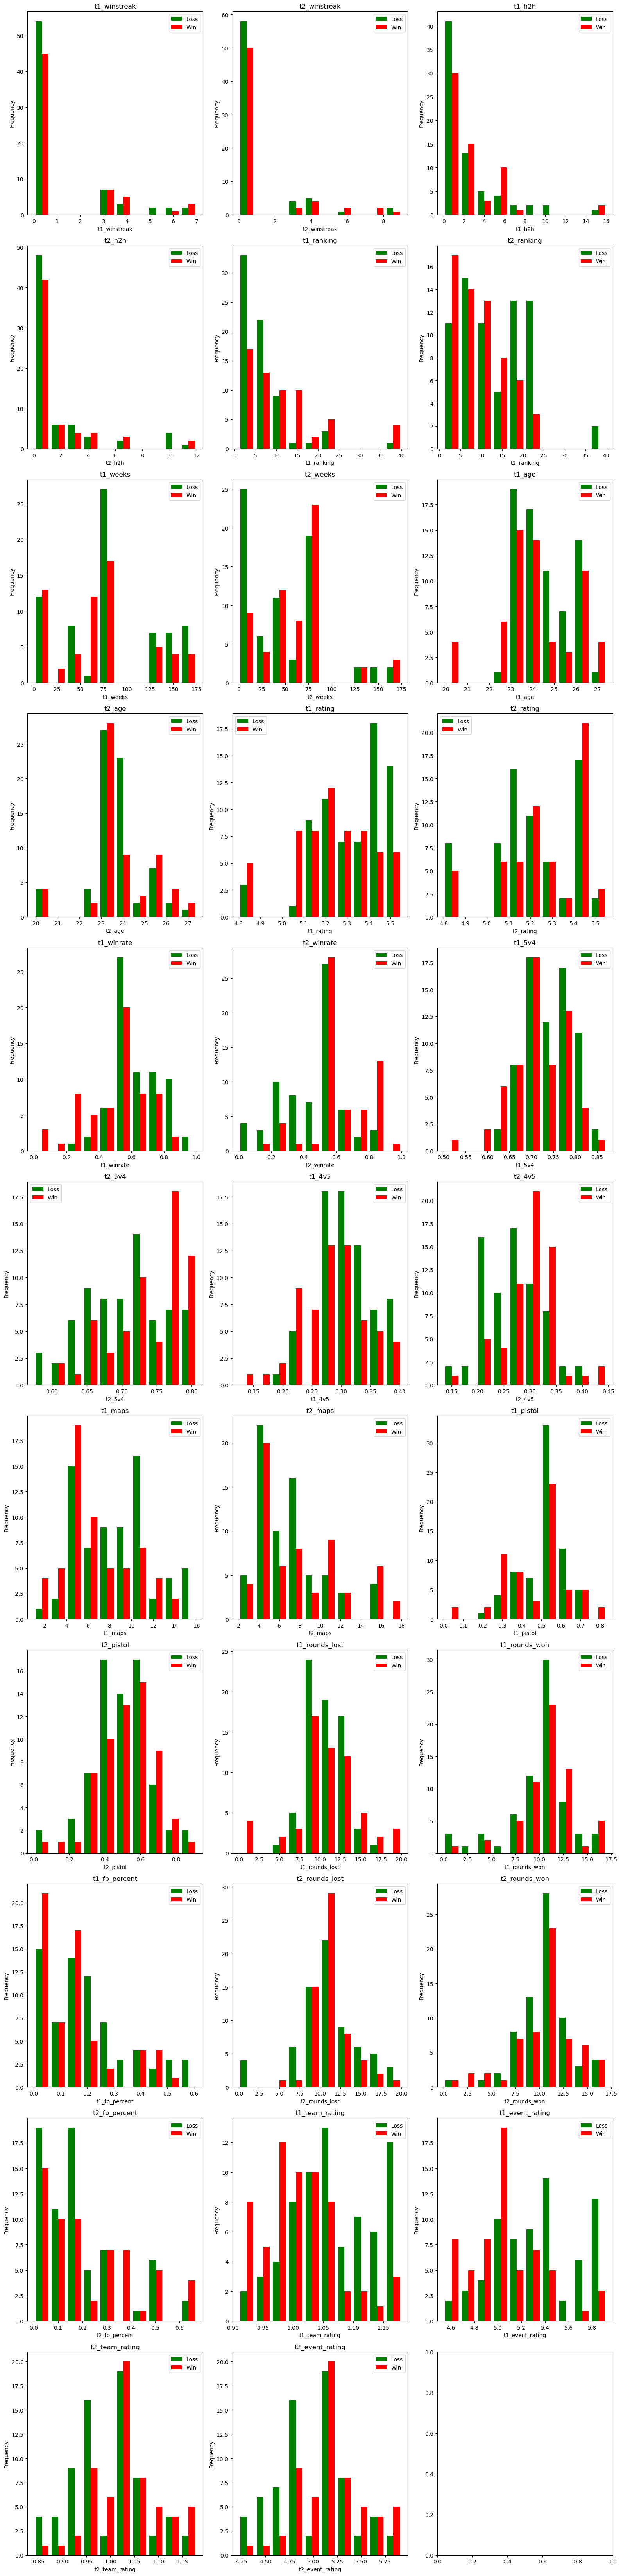

In [26]:
data_columns = [col for col in df.columns if col != 'win' and col != 't1_fp' and col != 't2_fp']

# Define the number of rows and columns for subplots
num_rows = 11
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))

index = 0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        if index < 32:
            axes[row,col].hist(x = [df[df['win']==1][data_columns[index]], df[df['win']==0][data_columns[index]]], 
            stacked=False, color = ['g','r'],label = ['Win','Lose'])
            axes[row,col].set_title(f'{data_columns[index]}')
            axes[row,col].set_xlabel(data_columns[index])
            axes[row,col].set_ylabel('Frequency')
            axes[row,col].legend(['Loss', 'Win'])
            index += 1

plt.tight_layout()
plt.show()